Imports

In [2078]:
import pandas as pd
import numpy as np
import requests
import plotly.express as px
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns


Reviewing a sample row from each file

In [2079]:
acquired = pd.read_csv("Data/Acquired Tech Companies.csv")
acquired.iloc[0]

Company                                                     Day Software
CrunchBase Profile     http://www.crunchbase.com/organization/day-sof...
Image                  http://a5.images.crunchbase.com/image/upload/c...
Tagline                Day Software develops web applications that al...
Year Founded                                                         NaN
Market Categories                                               Software
Address (HQ)           Barfüsserplatz 6, Basel, Basel-Stadt, Switzerland
City (HQ)                                                          Basel
State / Region (HQ)                                          Basel-Stadt
Country (HQ)                                                 Switzerland
Description            Day was founded in Basel, Switzerland, in 1993...
Homepage                                              http://www.day.com
Twitter                                                              NaN
Acquired by                                        

In [2080]:
acquiring = pd.read_csv("Data/Acquiring Tech Companies.csv")
acquiring.iloc[0]

Acquiring Company                                                                        Adobe
CrunchBase Profile                               www.crunchbase.com/organization/adobe-systems
Image                                        http://a2.images.crunchbase.com/image/upload/c...
Tagline                                      Adobe is an American multinational computer so...
Market Categories                            Photo Editing, Design, Creative, Software, Ima...
Year Founded                                                                              1982
IPO                                                                                       1986
Founders                                                         John Warnock, Charles Geschke
Number of Employees                                                                     11,144
Number of Employees (year of last update)                                               2012.0
Total Funding ($)                                 

In [2081]:
acquisitions = pd.read_csv("Data/Acquisitions.csv")
acquisitions.iloc[0]

Acquisitions ID                                      EMC acquired Data Domain in 2009
Acquired Company                                                          Data Domain
Acquiring Company                                                                 EMC
Year of acquisition announcement                                                 2009
Deal announced on                                                           8/07/2009
Price                                                                  $2,100,000,000
Status                                                                    Undisclosed
Terms                                                                            Cash
Acquisition Profile                 http://www.crunchbase.com/acquisition/5dc676a1...
News                                                         EMC acquired Data Domain
News Link                           http://www.businesswire.com/news/home/20090708...
Name: 0, dtype: object

In [2082]:
founders = pd.read_csv("Data/Founders and Board Members.csv")
founders.iloc[0]

Name                                                 Hans-Werner Hector
CrunchBase Profile      http://de.wikipedia.org/wiki/Hans-Werner_Hector
Role                                                            Founder
Companies                                                           SAP
Image                 http://images.forbes.com/media/lists/10/2006/4...
Name: 0, dtype: object

We will link between the files using these columns:
* Acquisitions ID to link the acquisitions
* 'Founders' and 'Name' to link the Founders

In [2083]:
np.intersect1d(acquired.columns, acquisitions.columns).tolist()

['Acquisitions ID']

In [2084]:
np.intersect1d(acquiring.columns, acquisitions.columns).tolist()

['Acquiring Company', 'Acquisitions ID']

In [2085]:
def ValidateLink(url, timeout=15):
    session = requests.Session()
    # fake headers to make it seem like a real request
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
        "Accept-Language": "en-US,en;q=0.9",
        "Accept-Encoding": "gzip, deflate, br",
        "Connection": "keep-alive",
        "Upgrade-Insecure-Requests": "1",
        "DNT": "1",
    }
    session.headers.update(headers)
    try:
        response = session.get(url, timeout=timeout, allow_redirects=True, stream=True)
        status_code = response.status_code
        response.close()
        if status_code < 400:
            return True
        else:
            return False
    except Exception as e:
        return False

In [2086]:
def ValidateLinks(urls):
    results = []
    for url in urls:
        results.append(ValidateLink(url))
        if results[-1]:
            return results
    return results

In [2087]:
def ValidateLinksDF(df):
    for col in df.columns:
        for val in df[col]:
            if type(val) == str and ("http" in val):
                print(col)
                results = ValidateLinks(df[col])
                if not pd.Series(results).any():
                    print(f'Column "{col}" had no valid links , or is using captcha.')
                    print("Try it yourself:")
                    print(df[col][0] + "\n")
                break

ValidateLinksDF(acquired)

* CrunchBase is using CAPTCHA , so we won't drop it now but we will process it later
* Image links are all corrupt so we will drop the column 

In [2088]:
acquired = acquired.drop("Image", axis=1)

ValidateLinksDF(acquiring)

* drop Image also

In [2089]:
acquiring = acquiring.drop("Image", axis=1)

ValidateLinksDF(acquisitions)

* acquisitions profile is also a crunchbase link

In [2090]:
acquisitions = acquisitions.drop("Acquisition Profile", axis=1)

ValidateLinksDF(founders)

We don't need the exact address of the company, we already have the city , state and country

In [2091]:
acquired = acquired.drop("Address (HQ)", axis=1)
acquiring = acquiring.drop("Address (HQ)", axis=1)

**Adding the target variable**

In [2092]:
acquisitions["Price"] = [
    int(price.removeprefix("$").replace(",", "")) for price in acquisitions["Price"]
]

In [2093]:
acquired["Price"] = None
acquired["Year of acquisition announcement"] = None

In [2094]:
for i, company in enumerate(acquisitions["Acquired Company"]):
    acquired.loc[acquired["Company"] == company, "Price"] = acquisitions.iloc[i][
        "Price"
    ]
    acquired.loc[acquired["Company"] == company, "Year of acquisition announcement"] = (
        acquisitions.iloc[i]["Year of acquisition announcement"]
    )

In [2095]:
fig = px.scatter(
    acquisitions,
    x="Year of acquisition announcement",
    y="Price",
    title="Acquisition Price by Year",
    width=600,
    height=400,
)
fig.show()

There was a wrongly entered value, so I looked at the link and corrected it

In [2096]:
acquisitions.loc[
    acquisitions["Year of acquisition announcement"] == 2104,
    "Year of acquisition announcement",
] = 2014

Plotting again without the error, now we can see that the overall trend of prices tends to go up, that's why we added the 'Year of acquisitions announcement' column

In [2097]:
fig = px.scatter(
    acquisitions,
    x="Year of acquisition announcement",
    y="Price",
    title="Acquisition Price by Year",
    width=700,
    height=400,
)
fig.show()

update the datatypes automatically

In [2098]:
acquired = acquired.infer_objects()
acquisitions = acquisitions.infer_objects()

In [2099]:
fig = px.scatter(
    acquired,
    x="Year Founded",
    y="Price",
    title="Acquisition Price by Year",
    width=600,
    height=400,
)
fig.show()

Another error found and corrected

In [2100]:
acquired.loc[acquired["Year Founded"] == 1840, "Year Founded"] = 2006
acquired.loc[acquired["Year Founded"] == 1933, "Year Founded"] = 1989

In [2101]:
fig = px.scatter(
    acquired,
    x="Year Founded",
    y="Price",
    title="Acquisition Price by Year",
    width=600,
    height=400,
)
fig.show()

In [2102]:
acquired.iloc[12]["Tagline"]

'5min Media is a syndication platform for lifestyle, knowledge and instructional videos.'

In [2103]:
for l in acquired.iloc[12]["Description"].split("."):
    print(l + "\n")

5min Media is the leading syndication platform for lifestyle, knowledge and instructional videos

 Reinventing the cable network online, 5min reaches engaged and targeted audiences of passionate consumers through its network of 100s of lifestyle and niche websites

 The 5min video library comprises more than 200,000 short-form videos from some of the world's largest media companies, as well as the most innovative independent producers

 Visit  for more information





* 'Tagline' contains a brief and precise description of the company , while the 'Description' is very long and doesn't provide any more important details, 
so we will drop the 'Description'

In [2104]:
acquiring = acquiring.drop("Description", axis=1)
acquired = acquired.drop("Description", axis=1)

### There isn't any new useful information that we can get out of those , so we will drop them

* "CrunchBase Profile" and "API" columns are both on the crunchbase website , which uses captcha so we can't scrap it, and their API is paid , and the provided API key is invalid , so we can't use it

* "Homepage" column contains the link to the website of every company , and they aren't all the same so we can't apply a function or a program to extract certain information about them. To use the link , this would require us to go over into each of them one by one , which isn't  feasible


* "Twitter" column also can't be scraped according to their new policy , tried multiple APIs and libraries but none of them worked , even twitter's free tier API is useless
 

* "Acquisition ID" is just used to link between files , and we can do that with the company's name


In [2105]:
acquired = acquired.drop(["CrunchBase Profile", "Homepage", "Twitter", "API"], axis=1)
acquiring = acquiring.drop(
    ["CrunchBase Profile", "Homepage", "Twitter", "Acquisitions ID", "API"], axis=1
)
founders = founders.drop("CrunchBase Profile", axis=1)

In [2106]:
acquired["Age on acquisition"] = (
    acquired["Year of acquisition announcement"] - acquired["Year Founded"]
)

In [2107]:
acquired = acquired.drop(["Year Founded", "Year of acquisition announcement"], axis=1)

All these columns are probably related to the target column , so we will keep them for now

Market categories contains multiple values , still not processed

In [2108]:
acquired.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Company              310 non-null    object 
 1   Tagline              307 non-null    object 
 2   Market Categories    287 non-null    object 
 3   City (HQ)            275 non-null    object 
 4   State / Region (HQ)  273 non-null    object 
 5   Country (HQ)         276 non-null    object 
 6   Acquired by          309 non-null    object 
 7   Acquisitions ID      310 non-null    object 
 8   Price                310 non-null    int64  
 9   Age on acquisition   241 non-null    float64
dtypes: float64(1), int64(1), object(8)
memory usage: 24.3+ KB


Dropping 'year of last update' of the number of employees , because we don't need it directly and can't use it in any way to pridct the current number

In [2109]:
acquiring = acquiring.drop("Number of Employees (year of last update)", axis=1)

There are multiple 'NOT YET' in the IPO column , and the earliest the number the better it is , so we won't replace them with zero ,we will replace them with 2025 or anything larger

In [2110]:
acquiring["IPO"].value_counts()[:5]

IPO
1986       4
1978       4
1983       2
Not yet    2
1990       2
Name: count, dtype: int64

In [2111]:
acquiring.loc[acquiring["IPO"] == "Not yet", "IPO"] = 2025  # 2025 is debatable

In [2112]:
acquiring["Number of Employees"] = [
    int(n.replace(",", "")) if type(n) != float else n
    for n in acquiring["Number of Employees"]
]

Idea for acquiring companies: calculate the average price paid for all acquired companies

how to categorize multiple values in the same cell?

In [2113]:
acquiring["Market Categories"][:5]

0    Photo Editing, Design, Creative, Software, Ima...
1    Groceries, Consumer Goods, Crowdsourcing, E-Co...
2    News, Advertising Platforms, Content Creators,...
3    Computers, Consumer Electronics, Hardware + So...
4                                               Mobile
Name: Market Categories, dtype: object

In [2114]:
acquiring = acquiring.astype(
    {
        "IPO": "float",
    }
)

In [2115]:
flattened = [x for item in acquiring["Board Members"].dropna() for x in item.split(",")]

In [2116]:
pd.Series(flattened).nunique()

309

In [2117]:
len(np.intersect1d(founders["Name"], flattened))

34

Some of the board members are in the founders df , so we won't drop them for now

In [199]:
acquiring.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Acquiring Company       36 non-null     object 
 1   Tagline                 36 non-null     object 
 2   Market Categories       36 non-null     object 
 3   Year Founded            36 non-null     int64  
 4   IPO                     35 non-null     float64
 5   Founders                36 non-null     object 
 6   Number of Employees     35 non-null     float64
 7   Total Funding ($)       36 non-null     int64  
 8   Number of Acquisitions  36 non-null     int64  
 9   Board Members           34 non-null     object 
 10  City (HQ)               34 non-null     object 
 11  State / Region (HQ)     33 non-null     object 
 12  Country (HQ)            36 non-null     object 
 13  Acquired Companies      36 non-null     object 
dtypes: float64(2), int64(3), object(9)
memory us

In [200]:
founders["Companies"].value_counts()[:5]

Companies
Microsoft                 21
IBM                       20
Cisco Systems             17
Verizon Communications    15
Nokia                     15
Name: count, dtype: int64

In [201]:
founders["Role"].value_counts()

Role
Board of Directors                    222
Founder                                79
Advisory Board                         72
Board of Directors, Advisory Board      4
Board Observer                          3
Board of Directors, Founder             2
Name: count, dtype: int64

The image of the founder doesn't affect anything at all ... DROPPED

In [202]:
founders = founders.drop("Image", axis=1)

Ready

In [2122]:
founders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name       382 non-null    object
 1   Role       382 non-null    object
 2   Companies  382 non-null    object
dtypes: object(3)
memory usage: 9.1+ KB


* The specific date which the deal was announced on doesn't matter , what matters is the year so the model can know that inflation affects the price
* The ID doesn't add any new info
* The News and News link don't add any info or details about the acquisition

In [204]:
acquisitions = acquisitions.drop(["Deal announced on", "News", "News Link"], axis=1)

In [205]:
acquisitions["Status"].value_counts()

Status
Undisclosed    310
Complete        16
Pending          9
Name: count, dtype: int64

In [206]:
acquisitions["Terms"].value_counts()

Terms
Undisclosed    148
Cash           128
Cash, Stock     36
Stock           24
Name: count, dtype: int64

In [207]:
acquisitions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Acquisitions ID                   336 non-null    object
 1   Acquired Company                  336 non-null    object
 2   Acquiring Company                 336 non-null    object
 3   Year of acquisition announcement  336 non-null    int64 
 4   Price                             336 non-null    int64 
 5   Status                            335 non-null    object
 6   Terms                             336 non-null    object
dtypes: int64(2), object(5)
memory usage: 18.5+ KB


In [208]:
df = acquired.copy()

In [209]:
renamed_columns = {}
for col in acquiring.columns:
    new_col = f"{col} (Acquiring)"
    renamed_columns[col] = new_col

acquiring = acquiring.rename(columns=renamed_columns)

for col in acquiring.columns:
    if col not in df.columns:
        df[col] = None

for i, row1 in df.iterrows():
    for j, row2 in acquiring.iterrows():
        if row1["Acquired by"] == row2["Acquiring Company (Acquiring)"]:
            for col in acquiring.columns:
                df.at[i, col] = row2[col]

In [210]:
df = df.drop("Acquired by", axis=1)  # delete a the duplicate column used for linking

In [211]:
renamed_columns = {}
for col in acquisitions.columns:
    new_col = f"{col} (Acquisitions)"
    renamed_columns[col] = new_col

acquisitions = acquisitions.rename(columns=renamed_columns)

for col in acquisitions.columns:
    if col not in df.columns:
        df[col] = None

for i, row1 in df.iterrows():
    for j, row2 in acquisitions.iterrows():
        if row1["Acquisitions ID"] == row2["Acquisitions ID (Acquisitions)"]:
            for col in acquisitions.columns:
                df.at[i, col] = row2[col]

Delete duplicate columns , and already used columns

In [2374]:
df[:3]

,Company,Tagline,Market Categories,City (HQ),State / Region (HQ),Country (HQ),Acquisitions ID,Price,Age on acquisition,Acquiring Company (Acquiring),...,State / Region (HQ) (Acquiring),Country (HQ) (Acquiring),Acquired Companies (Acquiring),Acquisitions ID (Acquisitions),Acquired Company (Acquisitions),Acquiring Company (Acquisitions),Year of acquisition announcement (Acquisitions),Price (Acquisitions),Status (Acquisitions),Terms (Acquisitions)
0,Day Software,Day Software develops web applications that al...,Software,Basel,Basel-Stadt,Switzerland,Adobe Systems acquired Day Software in 2010,240000000,NaN,Adobe,...,California,United States,"Accelio Corporation, Aldus Corp, Amicima, Ares...",Adobe Systems acquired Day Software in 2010,Day Software,Adobe,2010,240000000,Undisclosed,Cash
1,Efficient Frontier,"Efficient Frontier, an online performance and ...",Advertising,Sunnyvale,California,United States,Adobe Systems acquired Efficient Frontier in 2011,400000000,9.0,Adobe,...,California,United States,"Accelio Corporation, Aldus Corp, Amicima, Ares...",Adobe Systems acquired Efficient Frontier in 2011,Efficient Frontier,Adobe,2011,400000000,Undisclosed,Undisclosed
2,Macromedia,Macromedia is a graphics and web development s...,Software,San Francisco,California,United States,Adobe Systems acquired Macromedia in 2005,3400000000,13.0,Adobe,...,California,United States,"Accelio Corporation, Aldus Corp, Amicima, Ares...",Adobe Systems acquired Macromedia in 2005,Macromedia,Adobe,2005,3400000000,Undisclosed,Stock


In [2375]:
df = df.drop(
    [
        "Acquisitions ID",
        "Acquiring Company (Acquisitions)",
        "Acquired Company (Acquisitions)",
        "Acquisitions ID (Acquisitions)",
        "Price (Acquisitions)",
        "Year of acquisition announcement (Acquisitions)",
    ],
    axis=1,
)

In [213]:
df.loc[0]

Company                                                                    Day Software
Tagline                               Day Software develops web applications that al...
Market Categories                                                              Software
City (HQ)                                                                         Basel
State / Region (HQ)                                                         Basel-Stadt
Country (HQ)                                                                Switzerland
Price                                                                         240000000
Age on acquisition                                                                  NaN
Acquiring Company (Acquiring)                                                     Adobe
Tagline (Acquiring)                   Adobe is an American multinational computer so...
Market Categories (Acquiring)         Photo Editing, Design, Creative, Software, Ima...
Year Founded (Acquiring)        

In [2133]:
df.head()

,Company,Tagline,Market Categories,City (HQ),State / Region (HQ),Country (HQ),Price,Age on acquisition,Acquiring Company (Acquiring),Tagline (Acquiring),...,Number of Employees (Acquiring),Total Funding ($) (Acquiring),Number of Acquisitions (Acquiring),Board Members (Acquiring),City (HQ) (Acquiring),State / Region (HQ) (Acquiring),Country (HQ) (Acquiring),Acquired Companies (Acquiring),Status (Acquisitions),Terms (Acquisitions)
0,Day Software,Day Software develops web applications that al...,Software,Basel,Basel-Stadt,Switzerland,240000000,NaN,Adobe,Adobe is an American multinational computer so...,...,11144.0,0,38,NaN,San Jose,California,United States,"Accelio Corporation, Aldus Corp, Amicima, Ares...",Undisclosed,Cash
1,Efficient Frontier,"Efficient Frontier, an online performance and ...",Advertising,Sunnyvale,California,United States,400000000,9.0,Adobe,Adobe is an American multinational computer so...,...,11144.0,0,38,NaN,San Jose,California,United States,"Accelio Corporation, Aldus Corp, Amicima, Ares...",Undisclosed,Undisclosed
2,Macromedia,Macromedia is a graphics and web development s...,Software,San Francisco,California,United States,3400000000,13.0,Adobe,Adobe is an American multinational computer so...,...,11144.0,0,38,NaN,San Jose,California,United States,"Accelio Corporation, Aldus Corp, Amicima, Ares...",Undisclosed,Stock
3,Neolane,Neolane is a marketing technology provider dev...,Software,Arcueil,Ile-de-France,France,600000000,12.0,Adobe,Adobe is an American multinational computer so...,...,11144.0,0,38,NaN,San Jose,California,United States,"Accelio Corporation, Aldus Corp, Amicima, Ares...",Undisclosed,Undisclosed
4,Omniture,Omniture is an online marketing and web analyt...,"Software, Advertising",Orem,Utah,United States,1800000000,13.0,Adobe,Adobe is an American multinational computer so...,...,11144.0,0,38,NaN,San Jose,California,United States,"Accelio Corporation, Aldus Corp, Amicima, Ares...",Undisclosed,Stock


renamed_columns = {}
for col in founders.columns:
    new_col = f"{col} (Founders)"
    renamed_columns[col] = new_col

founders = founders.rename(columns=renamed_columns)

for col in founders.columns:
    if col not in df.columns:
        df[col] = None

for j, row1 in founders.iterrows():
    for i, row2 in df.iterrows():
        if row1["Name (Founders)"] in row2["Founders (Acquiring)"]:
            for col in founders.columns:
                df.at[i, col] = row2[col]

In [2134]:
print(df['Country (HQ)'].value_counts())


Country (HQ)
United States              221
Israel                      12
Great Britain               11
Canada                       6
Japan                        5
Switzerland                  3
Sweden                       3
Germany                      3
Denmark                      2
Australia                    2
Spain                        2
France                       1
China                        1
Finland                      1
Ireland                      1
United Stats of AMerica      1
United Arab Emirates         1
Name: count, dtype: int64


In [2135]:
df['Country (HQ)'] = df['Country (HQ)'].replace('United Stats of AMerica', 'United States')


In [2136]:
counts = df['Country (HQ)'].value_counts()
rare_countries = counts[counts < 3].index
df['Country (HQ)'] = df['Country (HQ)'].replace(rare_countries, 'Other')


### Spliting each multi-valued category to an array of categories

In [2377]:
def mergeDfColumns(df : pd.DataFrame, columns: [str]):
    newCol = []
    for column in columns:
        newCol = [*newCol,*df[column].dropna().tolist()]
    return newCol

In [2378]:
def SplitMultiValuedColumn(column):
    c = []
    for values in column:
        if type(values) == str:
            c.append([ value.strip() if type(value) == str else values for value in values.split(',') ])
        else:
            c.append(values)
    return c

In [215]:
def getUniqueLabels(column):
    uniqueLabels = set([])
    for labels in column:
        for label in labels:
            uniqueLabels.add(label)
    return np.ravel(list(uniqueLabels))

In [216]:
def encodeMultiValuedCategory(df, label: str, categories=[]):
    le = preprocessing.LabelEncoder()
    df[label] = SplitMultiValuedColumn(df[label])
    if len(categories) == 0:
        categories = getUniqueLabels(df[label].dropna())
    le.fit(categories)
    df[label] = [le.transform(values) if type(values) == list else values for values in df[label]]
    return le.classes_

In [217]:
def encodeCategory(df, label: str, categories=[]):
    nonNullIndex = df[label].notna()

    le = preprocessing.LabelEncoder()
    if len(categories) == 0:
        categories = df.loc[nonNullIndex, label]

    le.fit(categories)
    df.loc[nonNullIndex, label] = le.transform(df.loc[nonNullIndex, label])
    return le.classes_

In [218]:
def FindMultiValuedColumns(df):
    cols = []
    for col in df.columns:
        try:  # To skip numeric columns
            if (
                len(
                    [
                        value
                        for value in df[col].dropna().values
                        if len(value.split(",")) > 1
                    ]
                )
                > 1
            ):
                cols.append(col)
        except:
            pass
    return cols

In [219]:
FindMultiValuedColumns(df)

['Tagline',
 'Market Categories',
 'Tagline (Acquiring)',
 'Market Categories (Acquiring)',
 'Founders (Acquiring)',
 'Board Members (Acquiring)',
 'Acquired Companies (Acquiring)',
 'Terms (Acquisitions)']

In [220]:
encoded = np.intersect1d(df.columns, FindMultiValuedColumns(df))

In [2385]:
encoded

array(['Acquired Companies (Acquiring)', 'Board Members (Acquiring)',
       'Founders (Acquiring)', 'Market Categories',
       'Market Categories (Acquiring)', 'Tagline', 'Tagline (Acquiring)',
       'Terms (Acquisitions)'], dtype=object)

In [2386]:
df.iloc[0]

Company                                                                    Day Software
Tagline                               Day Software develops web applications that al...
Market Categories                                                              Software
City (HQ)                                                                         Basel
State / Region (HQ)                                                         Basel-Stadt
Country (HQ)                                                                Switzerland
Price                                                                         240000000
Age on acquisition                                                                  NaN
Acquiring Company (Acquiring)                                                     Adobe
Tagline (Acquiring)                   Adobe is an American multinational computer so...
Market Categories (Acquiring)         Photo Editing, Design, Creative, Software, Ima...
Year Founded (Acquiring)        

In [2387]:
founders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382 entries, 0 to 381
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name       382 non-null    object
 1   Role       382 non-null    object
 2   Companies  382 non-null    object
dtypes: object(3)
memory usage: 9.1+ KB


In [2388]:
sharedColumns = [
    [
        False,
        "City (HQ)",
        "City (HQ) (Acquiring)",
    ],
    [
        False,
        "Country (HQ)",
        "Country (HQ) (Acquiring)",
    ],
    [
        False,
        "State / Region (HQ)",
        "State / Region (HQ) (Acquiring)",
    ],
    [ 
        True,
        'Market Categories',
        'Market Categories (Acquiring)',
    ],
]

In [2389]:
for sharedColumn in sharedColumns:
    print(sharedColumn[1:][0])
    categories = getUniqueLabels(SplitMultiValuedColumn(mergeDfColumns(df,sharedColumn[1:])))
    print(categories)
    for column in sharedColumn[1:]:
        if sharedColumn[0]:
            print(encodeMultiValuedCategory(df,column,categories=categories))
        else:
            print(encodeCategory(df,column,categories=categories))

City (HQ)
['Carrollton' 'Montréal' 'Menlo Park' 'Toronto' 'Seattle' 'Mountain View'
 'Kfar Saba' 'Højbjerg' 'Ottawa' 'Fremont' 'Lowell' 'Geneva' 'Denver'
 'Redmond' 'Piscataway' 'Stockholm' 'Miamisburg' 'Dresden' 'Malmö' 'Plano'
 'Brooklyn' 'Shanghai' 'Halifax' 'Reading' 'Irving' 'Hertzelia Pituah'
 'Wayne' 'Bellevue' 'Usa' 'Austin' 'Gloucester' 'Tokyo' 'Basel' 'Arcueil'
 'San Francisco' 'Islandia' 'Boston' 'Vernon' 'Palo Alto' "Ra'anana"
 'Redwood City' 'Cupertino' 'Potomac Falls' 'Boulder' 'Neubiberg' 'Dublin'
 'Waterloo' 'Tagerwilen' 'Aliso Viejo' 'Philadelphia' 'Wilmington'
 'Fort Lee' 'Indianapolis' 'Bet Shemesh' 'Herzliya Pituach' 'Washington'
 'Alameda' 'Jersey City' 'Copenhagen' 'Caesarea' 'Fredericton' 'Cambridge'
 'Deerfield' 'Armonk' 'Sunnyvale' 'Newark' 'Belfast' 'Thousand Oaks'
 'San Diego' 'Whippany' 'Middleton' 'Santa Clara' 'Markham' 'Helsinki'
 'Round Rock' 'Waltham' 'Pleasant Grove' 'Finnmark' 'Brentwood' 'Milpitas'
 'Salt Lake City' 'Atlanta' 'Santa Monica' 'Atherton

In [2390]:
multiVAluedColumns = FindMultiValuedColumns(df.drop(["Tagline","Tagline (Acquiring)"],axis=1))
multiVAluedColumns

['Founders (Acquiring)',
 'Board Members (Acquiring)',
 'Acquired Companies (Acquiring)',
 'Terms (Acquisitions)']

In [2391]:
df["Board Members (Acquiring)"]

0                                                    NaN
1                                                    NaN
2                                                    NaN
3                                                    NaN
4                                                    NaN
                             ...                        
305    Michael Moritz, Peter Liguori, Misty Locke, Ma...
306    Michael Moritz, Peter Liguori, Misty Locke, Ma...
307    Michael Moritz, Peter Liguori, Misty Locke, Ma...
308    Michael Moritz, Peter Liguori, Misty Locke, Ma...
309    Michael Moritz, Peter Liguori, Misty Locke, Ma...
Name: Board Members (Acquiring), Length: 310, dtype: object

In [2392]:
for label in multiVAluedColumns:
    print(encodeMultiValuedCategory(df, label)[:5])

['Akio Morita' 'Alexander Graham Bell' 'Allen Blue' 'Andrew McCollum'
 'Andrew Viterbi']
['AJ Jaghori' 'Adam Grosser' 'Al Gore' 'Alex J. Mandl'
 'Alexander Gounares']
['2Web Technologies' '2dehands.be' '2ememain.be' '360Commerce'
 '3721 Internet Assistant']
['Cash' 'Stock' 'Undisclosed']


In [222]:
df["Terms (Acquisitions)"][:5]

0    [0]
1    [2]
2    [1]
3    [2]
4    [1]
Name: Terms (Acquisitions), dtype: object

In [2394]:
df.drop(encoded, axis=1).columns

Index(['Company', 'City (HQ)', 'State / Region (HQ)', 'Country (HQ)', 'Price',
       'Age on acquisition', 'Acquiring Company (Acquiring)',
       'Year Founded (Acquiring)', 'IPO (Acquiring)',
       'Number of Employees (Acquiring)', 'Total Funding ($) (Acquiring)',
       'Number of Acquisitions (Acquiring)', 'City (HQ) (Acquiring)',
       'State / Region (HQ) (Acquiring)', 'Country (HQ) (Acquiring)',
       'Status (Acquisitions)'],
      dtype='object')

In [2395]:
for col in df.drop(encoded, axis=1).columns:
    encodeCategory(df, col)

In [2396]:
founders

,Name,Role,Companies
0,Hans-Werner Hector,Founder,SAP
1,Akio Morita,Founder,Sony
2,Alexander Graham Bell,Founder,AT&T
3,Andrew Viterbi,Founder,Qualcomm
4,Bob Miner,Founder,Oracle
...,...,...,...
377,Jack Yuan,Founder,SanDisk
378,Sanjay Mehrotra,Founder,SanDisk
379,Jerry Modes,Founder,Teradata
380,David Hartke,Founder,Teradata


In [2397]:
for i in FindMultiValuedColumns(founders):
    print(encodeMultiValuedCategory(founders,i))
encodeCategory(founders,"Name")

['Advisory Board' 'Board Observer' 'Board of Directors' 'Founder']
['AOL' 'AT&T' 'Adobe' 'Amazon' 'Apple' 'BlackBerry' 'CA Technologies'
 'Cisco Systems' 'Comcast' 'Dell' 'Dropbox' 'EMC' 'Facebook' 'Google' 'HP'
 'IBM' 'Intel' 'Juniper Networks' 'LinkedIn' 'Microsoft' 'Nokia' 'Oracle'
 'Pinterest' 'Qualcomm' 'SAP' 'Salesforce' 'Samsung' 'Samsung Electronics'
 'SanDisk' 'Sony' 'Symantec' 'Teradata' 'Twitter' 'Verizon Communications'
 'Vodafone' 'Yahoo' 'eBay']


array(['Adam Grosser', 'Akio Morita', 'Al Gore', 'Alex J. Mandl',
       'Alexander Gounares', 'Alexander Graham Bell',
       'Alexey Timanovskiy', 'Ali Partovi', 'Allen Blue', 'Allen Miner',
       'Ambassador Charlene Barshefsky', 'Amy Banse', 'Andrea Jung',
       'Andrew McCollum', 'Andrew Viterbi', 'Anil Khatri',
       'Anita M. Sands', 'Ann M. Livermore', 'Ann Mather',
       'Arash Ferdowsi', 'Arthur D. Levinson', 'Arthur Kern',
       'Arun Sarin', 'Barbara Stymiest', 'Ben Silbermann',
       'Bengt Holmstrom', 'Benjamin Joe', 'Bert Nordberg', 'Bijan Sabet',
       'Bill Campbell', 'Bill Gates', 'Bill Hambrecht', 'Bing Gordon',
       'Biz Stone', 'Bob Calderoni', 'Bob Miner', 'Brian Halla',
       'Brian Herschaft', 'Brian Snyder', 'Bruce Brown', 'Bryan Schreier',
       'Byeong-Gi Lee', 'Byung-Chull Lee', 'C.Y. Lee', 'Candice Olson',
       'Carol Bartz', 'Charles Geschke', 'Charles H. Noski',
       'Charles Hilliard', 'Charles R. Lee', 'Charles Wang',
       'Chris Feathe

In [2398]:
founders

,Name,Role,Companies
0,142,[3],[24]
1,1,[3],[29]
2,5,[3],[1]
3,14,[3],[23]
4,35,[3],[21]
...,...,...,...
377,161,[3],[28]
378,339,[3],[28]
379,176,[3],[31]
380,70,[3],[31]


In [2399]:
df.loc[0]

Company                                                                              66
Tagline                               Day Software develops web applications that al...
Market Categories                                                                 [139]
City (HQ)                                                                             8
State / Region (HQ)                                                                   2
Country (HQ)                                                                          7
Price                                                                                81
Age on acquisition                                                                  NaN
Acquiring Company (Acquiring)                                                         2
Tagline (Acquiring)                   Adobe is an American multinational computer so...
Market Categories (Acquiring)                                    [107, 45, 37, 139, 73]
Year Founded (Acquiring)        

In [2148]:
df.head()

,Company,Tagline,Market Categories,City (HQ),State / Region (HQ),Country (HQ),Price,Age on acquisition,Acquiring Company (Acquiring),Tagline (Acquiring),...,Number of Employees (Acquiring),Total Funding ($) (Acquiring),Number of Acquisitions (Acquiring),Board Members (Acquiring),City (HQ) (Acquiring),State / Region (HQ) (Acquiring),Country (HQ) (Acquiring),Acquired Companies (Acquiring),Status (Acquisitions),Terms (Acquisitions)
0,66,Day Software develops web applications that al...,[117],8,2,7,81,NaN,2,[4],...,8,0,14,[303],18,0,5,"[24, 56, 75, 103, 127, 154, 180, 354, 364, 372...",2,[0]
1,73,"Efficient Frontier, an online performance and ...",[1],101,5,8,106,10.0,2,[4],...,8,0,14,[303],18,0,5,"[24, 56, 75, 103, 127, 154, 180, 354, 364, 372...",2,[2]
2,138,Macromedia is a graphics and web development s...,[117],91,5,8,158,14.0,2,[4],...,8,0,14,[303],18,0,5,"[24, 56, 75, 103, 127, 154, 180, 354, 364, 372...",2,[1]
3,163,Neolane is a marketing technology provider dev...,[117],2,19,5,118,13.0,2,[4],...,8,0,14,[303],18,0,5,"[24, 56, 75, 103, 127, 154, 180, 354, 364, 372...",2,[2]
4,179,Omniture is an online marketing and web analyt...,"[117, 1]",73,44,8,146,14.0,2,[4],...,8,0,14,[303],18,0,5,"[24, 56, 75, 103, 127, 154, 180, 354, 364, 372...",2,[1]


# Checking outliers for actual numeric values


- We have to chek first if those features are normally distributed or not

In [2149]:
from scipy.stats import shapiro

Price: p-value = 0.00000
NOT Normal 



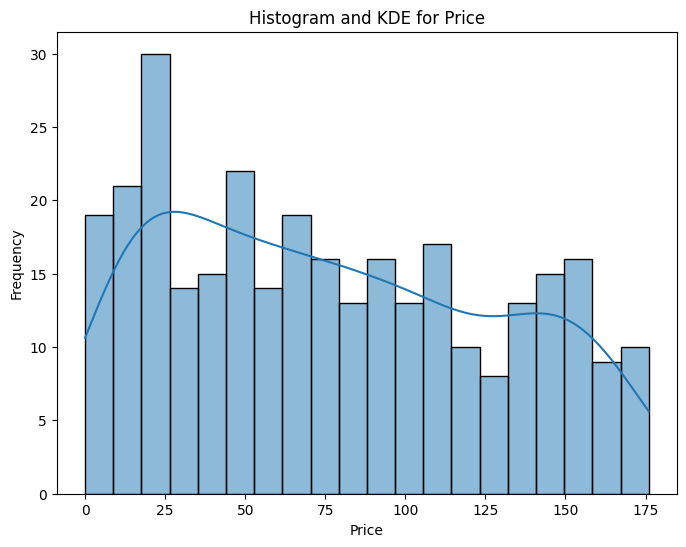

Age on acquisition: p-value = 0.00000
NOT Normal 



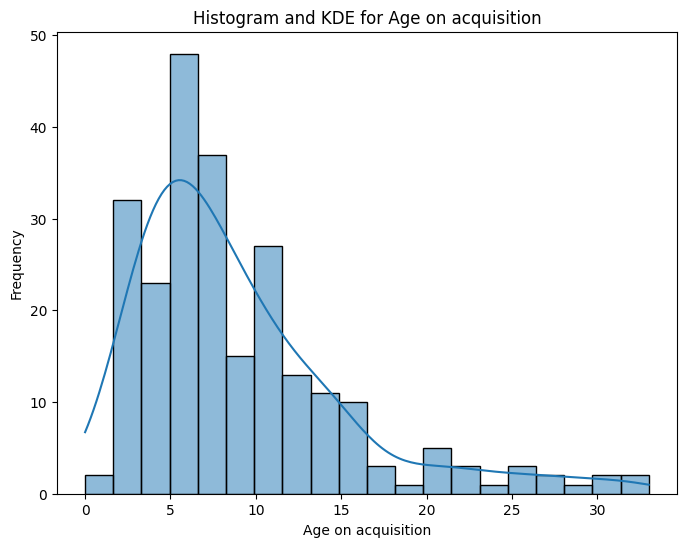

Number of Employees (Acquiring): p-value = 0.00001
NOT Normal 



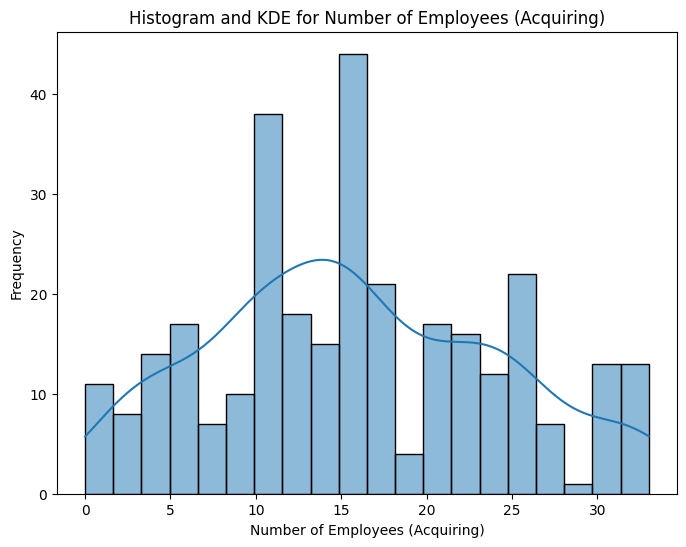

Total Funding ($) (Acquiring): p-value = 0.00000
NOT Normal 



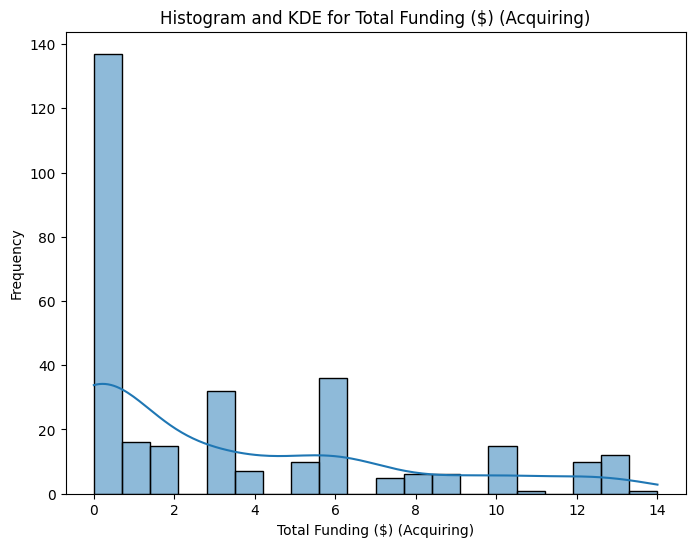

Number of Acquisitions (Acquiring): p-value = 0.00000
NOT Normal 



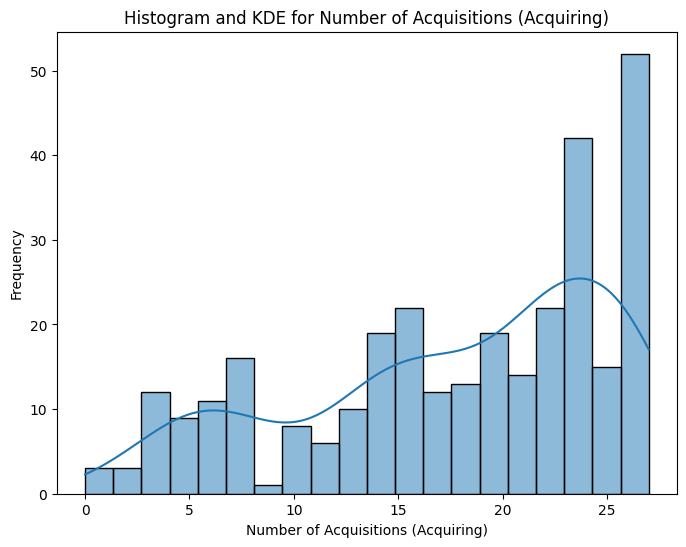

In [2150]:
numeric_cols = [
    'Price',
    'Age on acquisition',
    'Number of Employees (Acquiring)',
    'Total Funding ($) (Acquiring)',
    'Number of Acquisitions (Acquiring)',
]
for col in numeric_cols:
    stat, p = shapiro(df[col].dropna())
    print(f"{col}: p-value = {p:.5f}")
    if p > 0.05:
        print(" Normal \n")
    else:
        print("NOT Normal \n")
        
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col].dropna(), kde=True, bins=20)
    plt.title(f"Histogram and KDE for {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()



# Data isn't normally distributed so IQR method will be more effiecient


In [ ]:
outliers = {}

for col in numeric_cols:
    
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    outliers[col] = outlier_mask.sum()


print(pd.Series(outliers).sort_values(ascending=False))

Age on acquisition                    17
Price                                  0
Number of Employees (Acquiring)        0
Total Funding ($) (Acquiring)          0
Number of Acquisitions (Acquiring)     0
dtype: int64


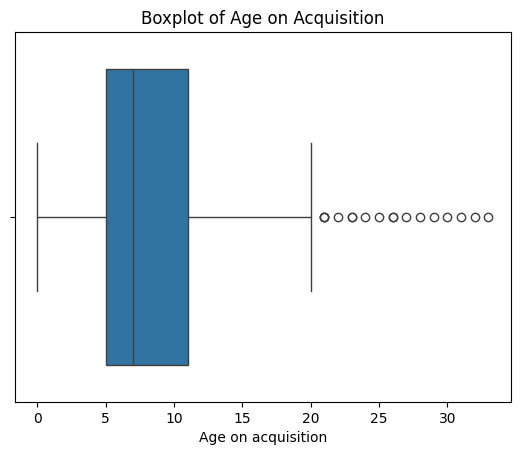

In [2152]:
sns.boxplot(x=df['Age on acquisition'])
plt.title("Boxplot of Age on Acquisition")
plt.show()


In [2153]:
median_value = df['Age on acquisition'].median()
df['Age on acquisition'] = df['Age on acquisition'].apply(
    lambda x: median_value if x < lower_bound or x > upper_bound else x
)


In [2154]:
for col in numeric_cols:
    print(f"{col} skew: {df[col].skew():.2f}")


Price skew: 0.28
Age on acquisition skew: 1.62
Number of Employees (Acquiring) skew: 0.22
Total Funding ($) (Acquiring) skew: 1.05
Number of Acquisitions (Acquiring) skew: -0.62


- Skewness of Total Funding and Age on aquisition is high so we can use log transformation to avoid data skewing 

In [2155]:
df['Total Funding ($) (Acquiring)'].apply(pd.to_numeric, errors='coerce').isnull().sum()


np.int64(1)

In [2156]:
df['Total Funding ($) (Acquiring)'].fillna(df['Total Funding ($) (Acquiring)'].median(), inplace=True)


C:\Users\Omar\AppData\Local\Temp\ipykernel_13904\2762218257.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\Omar\AppData\Local\Temp\ipykernel_13904\2762218257.py:1: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [2157]:
df['Age on acquisition'] = np.log(df['Age on acquisition'] + 1)
df['Total Funding ($) (Acquiring)'] = np.log(df['Total Funding ($) (Acquiring)'] + 1)

In [2158]:
for col in numeric_cols:
    print(f"{col} skew: {df[col].skew():.2f}")


Price skew: 0.28
Age on acquisition skew: 0.05
Number of Employees (Acquiring) skew: 0.22
Total Funding ($) (Acquiring) skew: 0.26
Number of Acquisitions (Acquiring) skew: -0.62


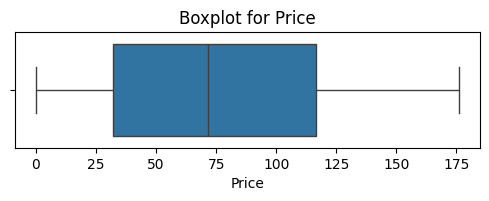

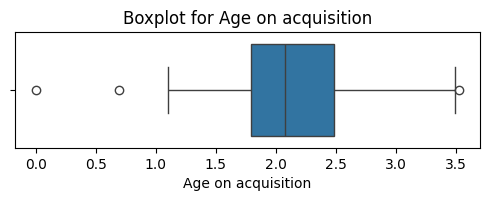

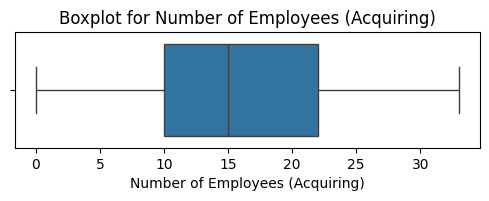

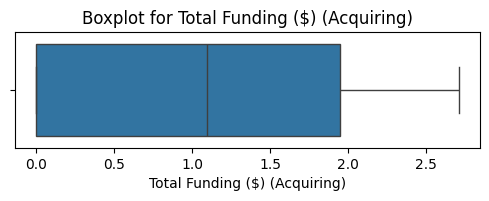

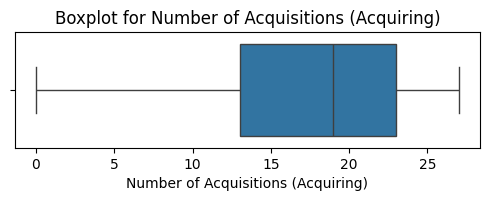

In [2159]:
for col in numeric_cols:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')
    plt.show()


### Imputing the null values


In [225]:
def knn_impute_numeric(df: pd.DataFrame, n_neighbors: int = 5) -> pd.DataFrame:

    df_copy = df.copy()

    numeric_cols = df_copy.select_dtypes(include=[float, int]).columns
    numeric_df = df_copy[numeric_cols]

    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_array = imputer.fit_transform(numeric_df)

    imputed_df = pd.DataFrame(imputed_array, columns=numeric_cols, index=df_copy.index)
    df_copy[numeric_cols] = imputed_df

    return df_copy

In [226]:
df.isnull().sum().sum()

np.int64(252)

In [227]:
df = knn_impute_numeric(df.infer_objects())

In [228]:
df.isnull().sum().sum()  # Tagline


np.int64(42)

In [229]:
numeric_df = df.select_dtypes(include=[float, int])
correlations = numeric_df.drop("Price", axis=1).apply(
    lambda x: abs(x.corr(numeric_df["Price"], method="kendall"))
)

In [2405]:
numeric_df

,Company,City (HQ),State / Region (HQ),Country (HQ),Price,Age on acquisition,Acquiring Company (Acquiring),Year Founded (Acquiring),IPO (Acquiring),Number of Employees (Acquiring),Total Funding ($) (Acquiring),Number of Acquisitions (Acquiring),City (HQ) (Acquiring),State / Region (HQ) (Acquiring),Country (HQ) (Acquiring),Status (Acquisitions)
0,66.0,8.0,2.0,13.0,81.0,8.4,2.0,12.0,4.0,8.0,0.0,14.0,18.0,0.0,5.0,2.0
1,73.0,101.0,5.0,15.0,106.0,10.0,2.0,12.0,4.0,8.0,0.0,14.0,18.0,0.0,5.0,2.0
2,138.0,91.0,5.0,15.0,158.0,14.0,2.0,12.0,4.0,8.0,0.0,14.0,18.0,0.0,5.0,2.0
3,163.0,2.0,19.0,5.0,118.0,13.0,2.0,12.0,4.0,8.0,0.0,14.0,18.0,0.0,5.0,2.0
4,179.0,73.0,44.0,15.0,146.0,14.0,2.0,12.0,4.0,8.0,0.0,14.0,18.0,0.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,239.0,91.0,5.0,15.0,7.0,3.0,33.0,17.0,11.0,10.0,3.0,23.0,21.0,0.0,5.0,2.0
306,258.0,91.0,5.0,15.0,10.0,3.0,33.0,17.0,11.0,10.0,3.0,23.0,21.0,0.0,5.0,2.0
307,268.0,76.0,5.0,15.0,42.0,5.0,33.0,17.0,11.0,10.0,3.0,23.0,21.0,0.0,5.0,2.0
308,270.0,79.8,20.6,12.4,24.0,7.6,33.0,17.0,11.0,10.0,3.0,23.0,21.0,0.0,5.0,2.0


In [2406]:
correlations.sort_values(ascending=False)

Age on acquisition                    0.368768
Year Founded (Acquiring)              0.206454
Total Funding ($) (Acquiring)         0.201643
IPO (Acquiring)                       0.178588
Country (HQ)                          0.167743
Number of Employees (Acquiring)       0.152101
State / Region (HQ) (Acquiring)       0.099589
Country (HQ) (Acquiring)              0.079755
State / Region (HQ)                   0.051131
Acquiring Company (Acquiring)         0.048023
City (HQ) (Acquiring)                 0.030493
Status (Acquisitions)                 0.017956
Company                               0.014899
City (HQ)                             0.014496
Number of Acquisitions (Acquiring)    0.014488
dtype: float64

In [231]:
df.head()

,Company,Tagline,Market Categories,City (HQ),State / Region (HQ),Country (HQ),Price,Age on acquisition,Acquiring Company (Acquiring),Tagline (Acquiring),...,Number of Employees (Acquiring),Total Funding ($) (Acquiring),Number of Acquisitions (Acquiring),Board Members (Acquiring),City (HQ) (Acquiring),State / Region (HQ) (Acquiring),Country (HQ) (Acquiring),Acquired Companies (Acquiring),Status (Acquisitions),Terms (Acquisitions)
0,66.0,Day Software develops web applications that al...,[139],8.0,2.0,13.0,81.0,8.4,2.0,Adobe is an American multinational computer so...,...,8.0,0.0,14.0,NaN,18.0,0.0,5.0,"[24, 56, 75, 103, 127, 154, 180, 354, 364, 372...",2.0,[0]
1,73.0,"Efficient Frontier, an online performance and ...",[1],101.0,5.0,15.0,106.0,10.0,2.0,Adobe is an American multinational computer so...,...,8.0,0.0,14.0,NaN,18.0,0.0,5.0,"[24, 56, 75, 103, 127, 154, 180, 354, 364, 372...",2.0,[2]
2,138.0,Macromedia is a graphics and web development s...,[117],91.0,5.0,8.0,158.0,2.708050,2.0,[4],...,8.0,0.0,14.0,[303],18.0,0.0,5.0,"[24, 56, 75, 103, 127, 154, 180, 354, 364, 372...",2.0,[1]
3,163.0,Neolane is a marketing technology provider dev...,[139],2.0,19.0,5.0,118.0,13.0,2.0,Adobe is an American multinational computer so...,...,8.0,0.0,14.0,NaN,18.0,0.0,5.0,"[24, 56, 75, 103, 127, 154, 180, 354, 364, 372...",2.0,[2]
4,179.0,Omniture is an online marketing and web analyt...,"[139, 1]",73.0,44.0,15.0,146.0,14.0,2.0,Adobe is an American multinational computer so...,...,8.0,0.0,14.0,NaN,18.0,0.0,5.0,"[24, 56, 75, 103, 127, 154, 180, 354, 364, 372...",2.0,[1]


In [232]:
df['Tagline'].isnull().sum()

np.int64(3)

In [233]:
df['Tagline'] = acquired['Tagline'].fillna('')


In [234]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

df['Tagline_Embedding'] = acquired['Tagline'].apply(lambda x: model.encode(str(x)).tolist())
df['Tagleline (aquiring)_Emb']=acquiring['Tagline (Acquiring)'].apply(lambda x: model.encode(str(x)).tolist())


In [235]:
df = df.drop("Tagline",axis=1)
df = df.drop("Tagline (Acquiring)",axis=1)

In [236]:
df.head()

,Company,Market Categories,City (HQ),State / Region (HQ),Country (HQ),Price,Age on acquisition,Acquiring Company (Acquiring),Market Categories (Acquiring),Year Founded (Acquiring),...,Number of Acquisitions (Acquiring),Board Members (Acquiring),City (HQ) (Acquiring),State / Region (HQ) (Acquiring),Country (HQ) (Acquiring),Acquired Companies (Acquiring),Status (Acquisitions),Terms (Acquisitions),Tagline_Embedding,Tagleline (aquiring)_Emb
0,66.0,[139],8.0,2.0,13.0,81.0,8.4,2.0,"[107, 45, 37, 139, 73]",12.0,...,14.0,NaN,18.0,0.0,5.0,"[24, 56, 75, 103, 127, 154, 180, 354, 364, 372...",2.0,[0],"[-0.03807872161269188, -0.012749378569424152, ...","[0.036320362240076065, -0.06904470920562744, -..."
1,73.0,[1],101.0,5.0,15.0,106.0,10.0,2.0,"[107, 45, 37, 139, 73]",12.0,...,14.0,NaN,18.0,0.0,5.0,"[24, 56, 75, 103, 127, 154, 180, 354, 364, 372...",2.0,[2],"[0.06601769477128983, -0.116398386657238, -0.1...","[0.024867577478289604, -0.05182826519012451, -..."
2,138.0,[139],91.0,5.0,15.0,158.0,14.0,2.0,"[107, 45, 37, 139, 73]",12.0,...,14.0,NaN,18.0,0.0,5.0,"[24, 56, 75, 103, 127, 154, 180, 354, 364, 372...",2.0,[1],"[0.051832638680934906, -0.06841100752353668, 0...","[-0.028975747525691986, -0.05876034498214722, ..."
3,163.0,[139],2.0,19.0,5.0,118.0,13.0,2.0,"[107, 45, 37, 139, 73]",12.0,...,14.0,NaN,18.0,0.0,5.0,"[24, 56, 75, 103, 127, 154, 180, 354, 364, 372...",2.0,[2],"[0.03702368587255478, -0.028293535113334656, -...","[0.0736999586224556, -0.03264852613210678, 0.0..."
4,179.0,"[139, 1]",73.0,44.0,15.0,146.0,14.0,2.0,"[107, 45, 37, 139, 73]",12.0,...,14.0,NaN,18.0,0.0,5.0,"[24, 56, 75, 103, 127, 154, 180, 354, 364, 372...",2.0,[1],"[-0.009346935898065567, 0.08956180512905121, -...","[-0.07472142577171326, 0.00847462099045515, 0...."


# TODO
* **there is 'None' values in Market Categories** probabily needs imputation but it's encoded
* scaling
* outliers
* embed Tagline
* What to do with founders